<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/Exploration/DCGAN/DCGAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir image
!mkdir history
!mkdir ckpt

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

In [3]:
cifar10 = tf.keras.datasets.cifar10
# mnist_fashion = tf.keras.datasets.fashion_mnist
(train_X  , _ ) , (test_X , _ ) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
train_X.shape , test_X.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
# 정규화
train_X = (train_X-127.5) / 127.5

In [6]:
# reshape
train_X = train_X.reshape(train_X.shape[0] , 32 , 32 , 3).astype('float32')
train_X.shape

(50000, 32, 32, 3)

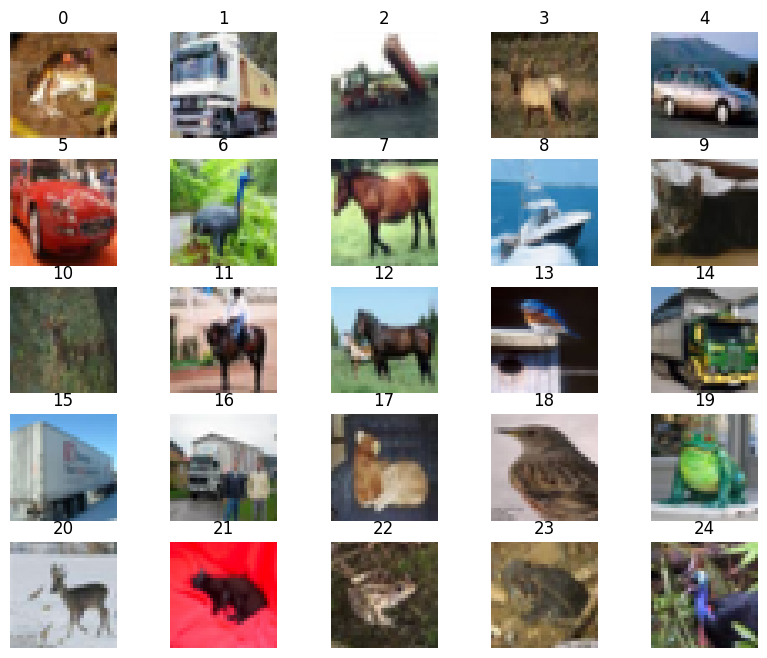

In [7]:
plt.figure(figsize = (10,8))
for i in range(25):
  plt.subplot(5,5,i+1)
  # idx = np.random.randint(1,60000)
  plt.imshow((train_X[i]+1)/2)
  plt.title(i)
  plt.axis('off')
plt.show()

In [8]:
# 파라미터
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [10]:
# 생성자 model Build

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 32, 32, 3)

  return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [12]:
# Gaussian vector
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

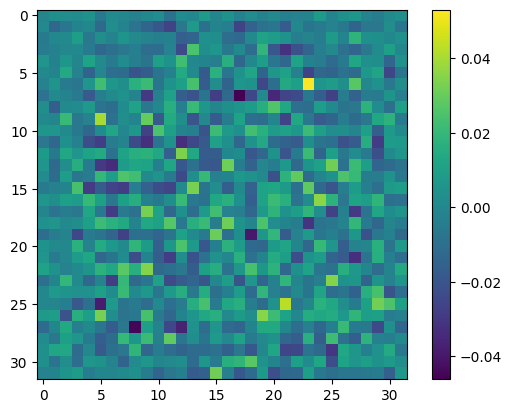

In [13]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [14]:
# 판별자 model Build

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0027822]], dtype=float32)>

In [17]:
# 손실 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 생성자 손실 함수 (True 에 가까워야)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# discriminator_loss (True 는 True , Fake 는  Fake)
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss+fake_loss
    return total_loss

In [20]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# Opimizer
generator_optimizer = tf.keras.optimizers.SGD(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# seed noise
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

<ipython-input-23-4cd5dc69b204>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seed)


<Axes: ylabel='Density'>

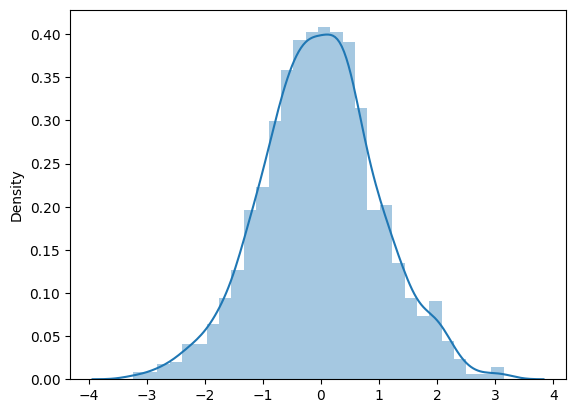

In [23]:
import seaborn as sns
sns.distplot(seed)

In [24]:
# train_step
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output ,fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


In [25]:
# 이미지 생성 저장.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2)
        plt.axis('off')

    plt.savefig(f'/content/image/sample_epoch_{epoch:04d}_iter_{it:03d}.png')

    plt.show()

In [26]:
plt.rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(f'/content/history/train_history_{epoch:04d}.png')
    plt.show()

In [27]:
# checkpoint
checkpoint_prefix = "/content/ckpt/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

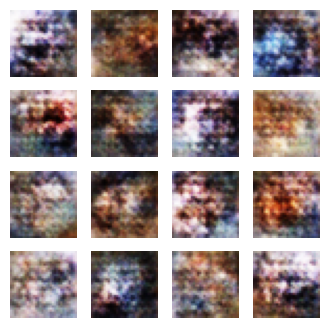

Time for training : 897 sec


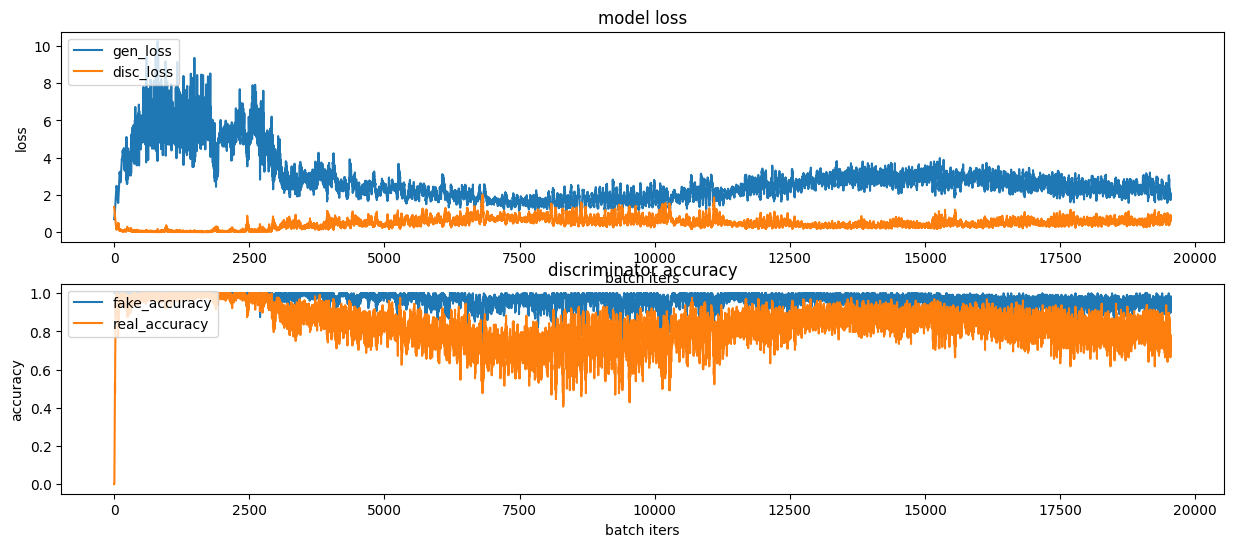

CPU times: user 8min 44s, sys: 1min 1s, total: 9min 45s
Wall time: 14min 59s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

## 1st DCGAN - Cifar10 Dataset

 - fake acuuracy 가 거의 1에 가까운 값이 나왔다는 것은 생성된 이미지의 정확도가 좋지 않다고 봐야 하는 것이 맞을 것 같다.

 - 실제로 생성된 이미지를 확인했을 때 어떤 이미지 인지 도 알아 보기 어려우며,epoch 30 부터는 지표의 개선이 없는 것을 확인 했다.

 - 여기서 epoch 을 더 준다고 해서 달라질 것은 없어 보이기 때문에 Model 을 개선 해보기로 한다.

In [148]:
# 파라미터
BUFFER_SIZE = 50000
BATCH_SIZE = 128
save_every = 5

In [149]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [150]:
# Opimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [151]:
# 개선1
# 생성자 model Build
def make_generator_model2():
  model = tf.keras.Sequential()
  model.add(layers.Dense(4*4*256, activation = 'relu' , use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Reshape((4, 4, 256)))

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  # output layer
  model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

In [152]:
generator2 = make_generator_model2()

generator2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 4096)              409600    
                                                                 
 batch_normalization_52 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_98 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_14 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_39 (Conv2D  (None, 8, 8, 128)        524288    
 Transpose)                                                      
                                                                 
 batch_normalization_53 (Bat  (None, 8, 8, 128)      

In [153]:
noise = tf.random.normal([1, 100])

generated_image = generator2(noise, training=False)

In [154]:
# 개선1
# 판별자 model Build

def make_discriminator_model2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512 , activation = 'relu'))
    model.add(layers.Dense(1 , activation = 'sigmoid'))

    return model

In [155]:
discriminator2 = make_discriminator_model2()

discriminator2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_102 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_103 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 4, 4, 256)       

In [156]:
decision = discriminator2(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50005215]], dtype=float32)>

In [157]:
# train_step
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator2(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator2(images, training=True)
        fake_output = discriminator2(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output ,fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [158]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator2, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator2, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

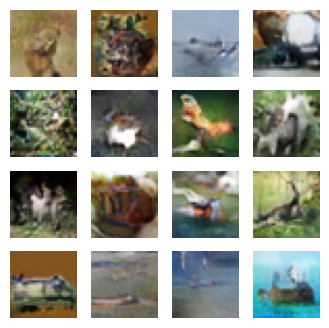

Time for training : 7297 sec


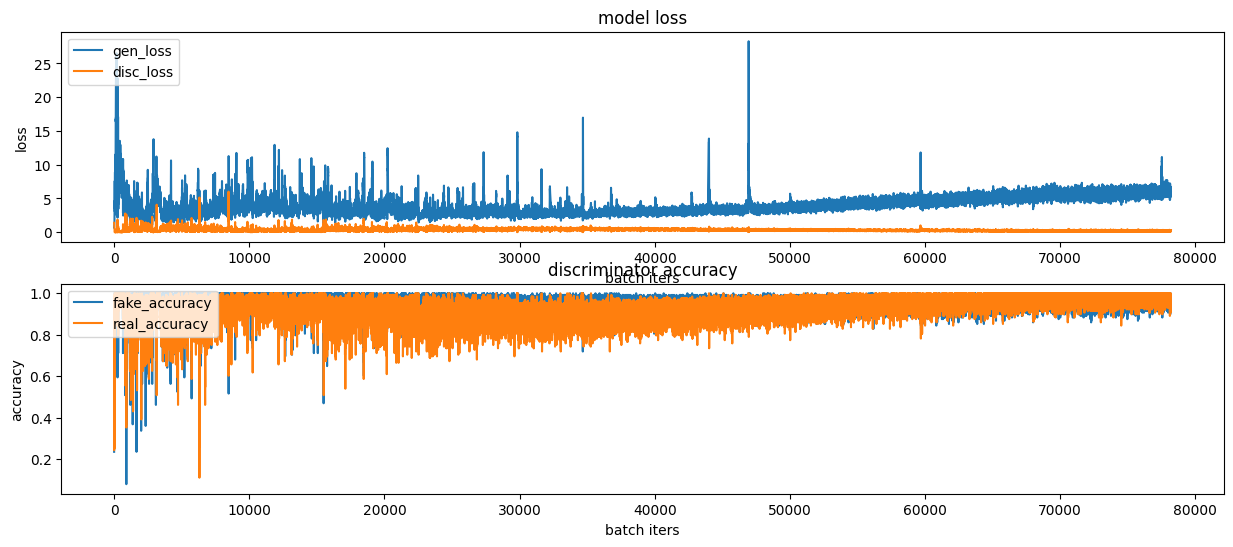

CPU times: user 49min 20s, sys: 5min 21s, total: 54min 42s
Wall time: 2h 1min 43s


In [159]:
# 개선후 1st test
%%time
EPOCHS = 200
train(train_dataset, EPOCHS, save_every)

## 성능 개선을 위한 참조 사이트

 - ref : https://zzcojoa.tistory.com/88
 - ref : https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
 - ref : https://www.kaggle.com/code/laszlofazekas/cifar10-dcgan-example


In [161]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/aiffel/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/image/sample_*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-161-08cef59f9c67>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-161-08cef59f9c67>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# Quset 고찰

1. 1st test

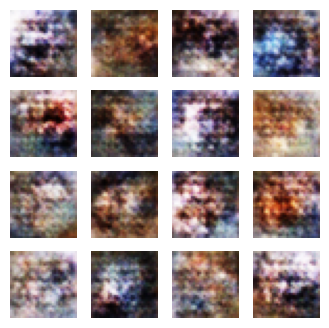


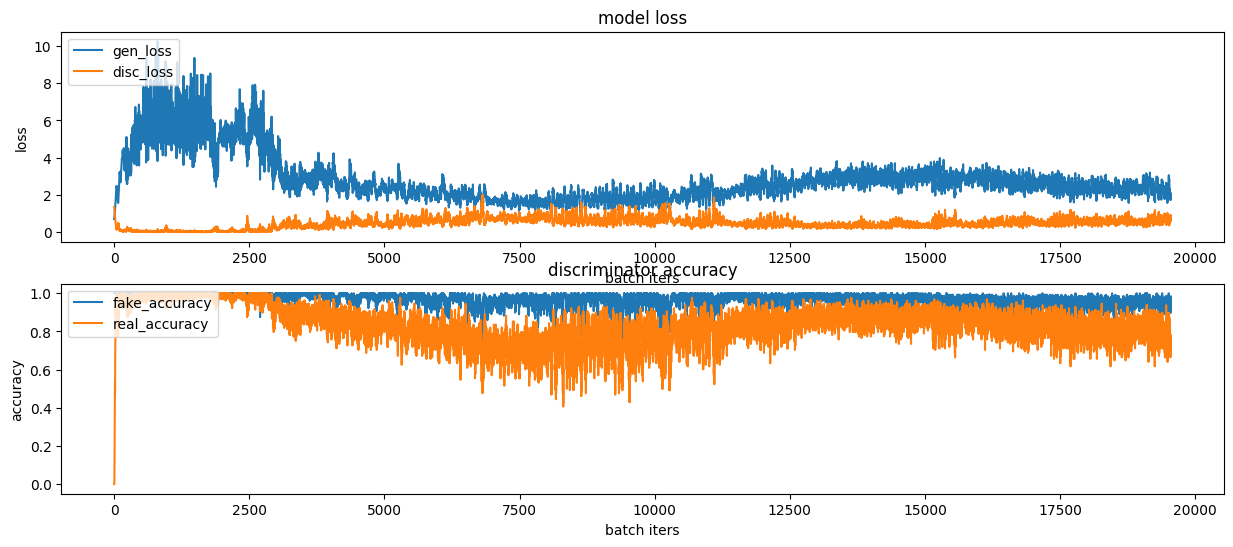

 - 위의 test 이미지 와 지표에서 확인 되듯이 , 만족할만한 지표도 결과도 아닌 것 같다.

 - 그래서 2nd test 에서는 generator 과 discriminator 의 layer를 추가 하여 test 를 진행 하였다. 또한 Epoch 도 50회에서 200회로 증가 시켰다.

2. 2nd Test 이미지 와 지표

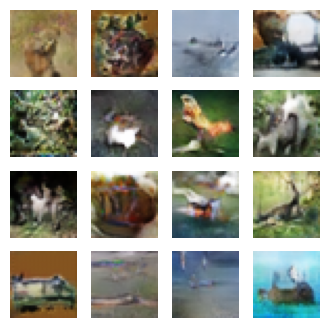

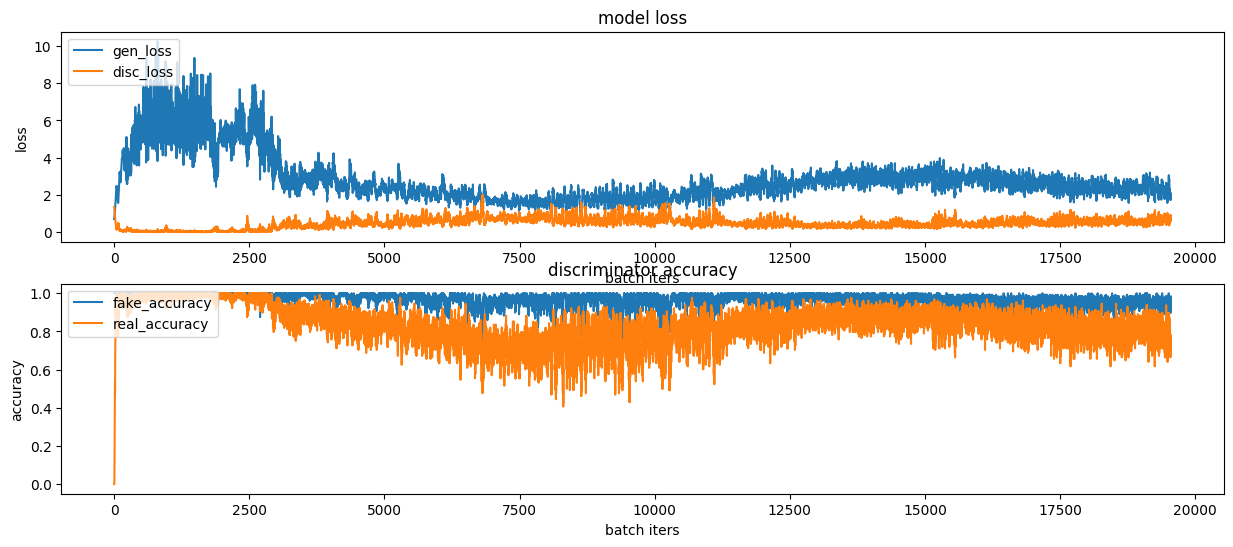

 - 처음 test 에 비해서 이미지의 객체가 구분이 가능한 수준 까지는 되는 것 같지만 , 아직 정확한 구분은 어려운 것 같다.

 - 다만 이 결과가 Epoch 에 의한 것인지 , 아니면 model 개선에 의한 것인지는 설명이 어렵다.

 - chatGPT 의 조언을 요약해 보면 Epoch 이 깡패 같은 느낌이 드는 것 처럼 느껴지기도 한다.

3. 추가 개선 사항.

 - 최적화 방법 에서 'beta1'을 조정 하고 , discriminator의 traing을 False 로 해보고자 한다.
 - 이 부분에 대해서는 추후 다시 업로드 하기로 한다.